# Benchmarking pipeline

Biological activities can be estimated by coupling a statistical method with a prior knowledge network. However, it is not clear which method or network performs better. When perturbation experiments are available, one can benchmark these methods by evaluating how good are they at recovering perturbed regulators. In our original `decoupler` [publication](https://doi.org/10.1093/bioadv/vbac016), we observed that `wsum`, `mlm`, `ulm` and `consensus` where the top performer methods. 

In this notebook we showcase how to use `decoupler` for the benchmarking of methods and prior knowledge networks. The data used here consist of single-gene perturbation experiments from the [KnockTF2](http://www.licpathway.net/KnockTFv2/index.php) database, an extensive dataset of literature curated perturbation experiments. If you use these data for your resarch, please cite the original publication of the resource:

>Chenchen Feng, Chao Song, Yuejuan Liu, Fengcui Qian, Yu Gao, Ziyu Ning, Qiuyu Wang, Yong Jiang, Yanyu Li, Meng Li, Jiaxin Chen, Jian Zhang, Chunquan Li, KnockTF: a comprehensive human gene expression profile database with knockdown/knockout of transcription factors, Nucleic Acids Research, Volume 48, Issue D1, 08 January 2020, Pages D93–D100, https://doi.org/10.1093/nar/gkz881

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages.

In [1]:
import pandas as pd
import numpy as np

import decoupler as dc

## Loading the data

We can download the data easily from Zenodo:

In [2]:
!wget 'https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1' -O knockTF_expr.csv
!wget 'https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1' -O knockTF_meta.csv

--2022-09-01 14:40:45--  https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146086808 (139M) [text/plain]
Saving to: ‘knockTF_expr.csv’

knockTF_expr.csv    100%[===================>] 139,32M  4,62MB/s    in 31s     

2022-09-01 14:41:18 (4,43 MB/s) - ‘knockTF_expr.csv’ saved [146086808/146086808]

--2022-09-01 14:41:18--  https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144861 (141K) [text/plain]
Saving to: ‘knockTF_meta.csv’

knockTF_meta.csv    100%[===================>] 141,47K  --.-KB/s    in 0,03s   

2022-09-01 14:41:19 (4,25 MB/s) - ‘knockTF_meta.csv’ saved [144861/144861]



We can then read it using `pandas`:

In [3]:
# Read data
mat = pd.read_csv('knockTF_expr.csv', index_col=0)
obs = pd.read_csv('knockTF_meta.csv', index_col=0)

`mat` consist of a matrix of logFCs between the perturbed and the control samples. Positive values mean that these genes were
overexpressed after the perturbation, negative values mean the opposite.

In [4]:
mat

,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AA06,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
DataSet_01_001,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,-0.033220,-0.046900,-0.143830,0.00000
DataSet_01_002,-0.173750,0.000000,-0.537790,-0.4424,-1.596640,-0.00010,-0.08260,-3.64590,0.0,0.0,...,0.000000,0.39579,0.000000,0.086110,0.28574,-0.130210,-0.276640,-0.881580,0.812950,0.47896
DataSet_01_003,-0.216130,0.000000,-0.220270,-0.0008,0.000000,0.15580,-0.35802,-0.32025,0.0,0.0,...,0.000000,-0.82964,0.000000,0.064470,0.59323,0.313950,-0.232600,0.065510,-0.147140,0.00000
DataSet_01_004,-0.255680,0.111050,-0.285270,0.0000,-0.035860,-0.46970,0.18559,-0.25601,0.0,0.0,...,0.000000,-0.39888,0.000000,0.104440,-0.16434,0.191460,0.415610,0.393840,0.127900,0.00000
DataSet_01_005,0.478500,-0.375710,-0.847180,0.0000,3.354450,0.17104,-0.34852,-0.95517,0.0,0.0,...,0.000000,0.24849,0.000000,-0.286920,-0.01815,0.119410,0.077850,0.234740,0.228690,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataSet_04_039,0.668721,0.000000,0.120893,0.0000,0.263564,0.00000,0.00000,0.00000,0.0,0.0,...,-0.324808,0.00000,-0.370491,0.092874,0.00000,0.014075,-0.215169,0.141374,-0.076054,0.00000
DataSet_04_040,1.816027,0.000000,0.139721,0.0000,0.459498,0.00000,0.00000,0.00000,0.0,0.0,...,-0.321726,0.00000,-0.144934,-0.238343,0.00000,-0.134995,0.577406,0.082028,-0.171424,0.00000
DataSet_04_041,-0.174250,0.000000,-0.084499,0.0000,0.112492,0.00000,0.00000,0.00000,0.0,0.0,...,0.405369,0.00000,0.272526,-0.125475,0.00000,0.019763,-0.098584,0.072675,0.199813,0.00000
DataSet_04_042,0.976681,0.000000,0.099845,0.0000,0.366973,0.00000,0.00000,0.00000,0.0,0.0,...,0.397698,0.00000,-0.398350,0.037134,0.00000,0.409704,-0.056978,0.308122,-0.058794,0.00000


On the other hand, `obs` contains the meta-data information of each perturbation experiment.
Here one can find which TF was perturbed (`TF` column), and many other useful information.

In [5]:
obs

,TF,Species,Knock.Method,Biosample.Name,Profile.ID,Platform,TF.Class,TF.Superclass,Tissue.Type,Biosample.Type,Data.Source,Pubmed.ID,logFC
DataSet_01_001,ESR1,Homo sapiens,siRNA,MCF7,GSE10061,GPL3921,Nuclear receptors with C4 zinc fingers,Zinc-coordinating DNA-binding domains,Mammary_gland,Cell line,GEO,18631401,-0.713850
DataSet_01_002,HNF1A,Homo sapiens,shRNA,HuH7,GSE103128,GPL18180,Homeo domain factors,Helix-turn-helix domains,Liver,Cell line,GEO,29466992,0.164280
DataSet_01_003,MLXIP,Homo sapiens,shRNA,HA1ER,GSE11242,GPL4133,Basic helix-loop-helix factors (bHLH),Basic domains,Embryo_kidney,Stem cell,GEO,18458340,0.262150
DataSet_01_004,CREB1,Homo sapiens,shRNA,K562,GSE12056,GPL570,Basic leucine zipper factors (bZIP),Basic domains,Haematopoietic_and_lymphoid_tissue,Cell line,GEO,18801183,-0.950180
DataSet_01_005,POU5F1,Homo sapiens,siRNA,GBS6,GSE12320,GPL570,Homeo domain factors,Helix-turn-helix domains,Bone_marrow,Cell line,GEO,20203285,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataSet_04_039,SRPK2,Homo sapiens,CRISPR,HepG2,ENCSR929EIP,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-1.392551
DataSet_04_040,WRN,Homo sapiens,shRNA,HepG2,ENCSR093FHC,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-0.173964
DataSet_04_041,YBX1,Homo sapiens,CRISPR,HepG2,ENCSR548OTL,-,Cold-shock domain factors,beta-Barrel DNA-binding domains,Liver,Cell line,ENCODE,22955616,-2.025170
DataSet_04_042,ZC3H8,Homo sapiens,shRNA,HepG2,ENCSR184YDW,-,C3H zinc finger factors,Zinc-coordinating DNA-binding domains,Liver,Cell line,ENCODE,22955616,-0.027152


## Filtering

Since some of the experiments collected inside KnockTF are of low quality, it is best to remove them. We can do this by filtering
perturbation experiments where the knocked TF does not show a strong negative logFC (meaning that the knock method did not work).


In [6]:
# Filter out low quality experiments (positive logFCs in knockout experiments)
msk = obs['logFC'] < -1
mat = mat[msk]
obs = obs[msk]
mat.shape, obs.shape

((388, 21985), (388, 13))

## Evaluation

### Single network

As an example, we will evaluate the gene regulatory network
[DoRothEA](https://saezlab.github.io/dorothea/), for more information you can visit this
[other vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

We can retrieve this network by running:

In [7]:
net = dc.get_dorothea(levels=['A', 'B', 'C', 'D'])
net

,source,confidence,target,weight
0,TP53,A,CCNG1,1.00
1,FOS,A,IL1A,1.00
2,FOS,A,IL1B,1.00
3,HIF1A,A,NOS3,1.00
4,MYC,A,RBM8A,1.00
...,...,...,...,...
276829,FOXA1,D,ARHGDIB,0.25
276830,FOXA1,D,ARHGEF1,0.25
276831,FOXA1,D,ARHGEF10L,0.25
276832,FOXA1,D,ARHGAP25,0.25


We will run the benchmark pipeline using the top performer methods from `decoupler`. If we would like, we could use any other,
and we can optionaly change their parametters too (for more information check the `decouple` function).

To run the benchmark pipeline, we need input molecular data (`mat`), its associated metadata (`obs`) with the name of the
column where the perturbed regulators are (`perturb`), and which direction the pertrubations are (`sign`, positive or negative).

In [8]:
# Example on how to set up decouple arguments
decouple_kws={
    'args' : {
        'wsum' : {'times': 100}
    }
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, net, perturb='TF', sign=-1, verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
146 experiments without sources in net, they will be removed.
Running methods...
52 features of mat are empty, they will be removed.
Running mlm on mat with 242 samples and 21933 targets for 411 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


52 features of mat are empty, they will be removed.
Running ulm on mat with 242 samples and 21933 targets for 411 sources.
52 features of mat are empty, they will be removed.
Running wsum on mat with 242 samples and 21933 targets for 411 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.45s/it]


Calculating metrics...
Computing metrics...
Done.


The result of running the pipeline is a long-format dataframe containing different performance metrics across methods:

- `auroc`: Area Under the Receiver Operating characteristic Curve (AUROC)
- `auprc`: Area Under the Precision-Recall Curve (AUPRC), which by default uses a calibrated version where 0.5 indicates a random classifier (adapted from [this publication](https://doi.org/10.1007/978-3-030-44584-3_36)).
- `mauroc`: Monte-Carlo Area Under the Precision-Recall Curve (AUPRC)
- `mauprc`: Monte-Carlo Area Under the Receiver Operating characteristic Curve (AUROC)

The Monte-Carlo metrics perform random permutations where each one samples the same number of true positives and true negatives to have balanced sets, returning one value per iteration done (10k by default).

In [9]:
df

,groupby,group,source,method,metric,score,ci
0,None,None,None,mlm_estimate,auroc,0.620085,0.002433
1,None,None,None,mlm_estimate,auprc,0.685880,0.002433
2,None,None,None,mlm_estimate,mcauroc,0.617035,0.002433
3,None,None,None,mlm_estimate,mcauroc,0.615669,0.002433
4,None,None,None,mlm_estimate,mcauroc,0.626153,0.002433
...,...,...,...,...,...,...,...
12007,None,None,None,consensus_estimate,mcauprc,0.696939,0.002433
12008,None,None,None,consensus_estimate,mcauprc,0.683277,0.002433
12009,None,None,None,consensus_estimate,mcauprc,0.647504,0.002433
12010,None,None,None,consensus_estimate,mcauprc,0.673727,0.002433


We can easily visualize the results in a scatterplot: 

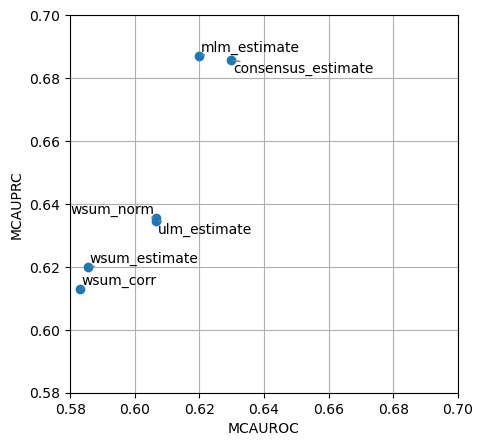

In [10]:
dc.plot_metrics_scatter(df, x='mcauroc', y='mcauprc')

It looks like `mlm` and the `consensus` methods are the best performers at recovering perturbed regulators.
We can also visualise the distirbutions of the obtained Monte-Carlo metrics, for example `mcauroc`:

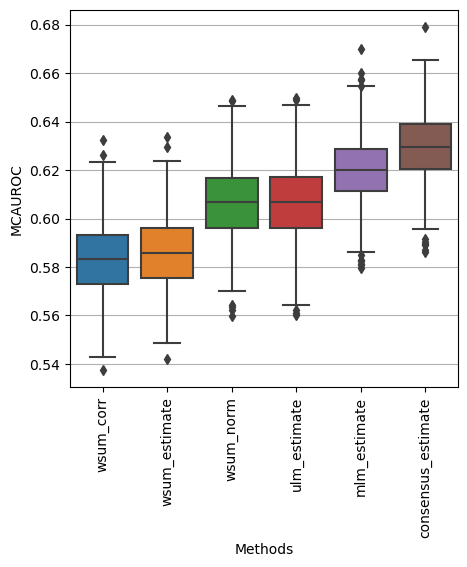

In [11]:
dc.plot_metrics_boxplot(df, metric='mcauroc')

### Multiple networks

This pipeline can evaluate multiple networks at the same time. Now we will evaluate different levels of confidence of DoRothEA (before we were using all of them, ABCD) and we will also add a randomized version as control. 

In [12]:
# Filter net into different confidence levels
doro_A = net[net['confidence'] == 'A']
doro_AB = net[np.isin(net['confidence'], ['A', 'B'])] 
doro_ABC = net[np.isin(net['confidence'], ['A', 'B', 'C'])]
doro_ABCD = net
doro_rand = dc.shuffle_net(doro_ABC, target='target', weight='weight').drop_duplicates(['source', 'target'])

We can run the same pipeline but now using a dictionary of networks (and of extra arguments if needed):

In [13]:
# Build dictionary of networks to test
nets = {
    'A': doro_A,
    'AB': doro_AB,
    'ABC': doro_ABC,
    'ABCD': doro_ABCD,
    'rand': doro_rand
}

# Example extra arguments
decouple_kws = {
    'A': {'args' : {'wsum' : {'times': 100}}},
    'AB': {'args' : {'wsum' : {'times': 100}}},
    'ABC': {'args' : {'wsum' : {'times': 100}}},
    'ABCD': {'args' : {'wsum' : {'times': 100}}},
    'rand': {'args' : {'wsum' : {'times': 100}}}
    
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, nets, perturb='TF', sign=-1, verbose=True, decouple_kws=decouple_kws)

Using A network...
Extracting inputs...
Formating net...
232 experiments without sources in net, they will be removed.
Running methods...
70 features of mat are empty, they will be removed.
Running mlm on mat with 156 samples and 21915 targets for 146 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


70 features of mat are empty, they will be removed.
Running ulm on mat with 156 samples and 21915 targets for 146 sources.
70 features of mat are empty, they will be removed.
Running wsum on mat with 156 samples and 21915 targets for 146 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


Calculating metrics...
Computing metrics...
Done.
Using AB network...
Extracting inputs...
Formating net...
218 experiments without sources in net, they will be removed.
Running methods...
70 features of mat are empty, they will be removed.
Running mlm on mat with 170 samples and 21915 targets for 172 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


70 features of mat are empty, they will be removed.
Running ulm on mat with 170 samples and 21915 targets for 172 sources.
70 features of mat are empty, they will be removed.
Running wsum on mat with 170 samples and 21915 targets for 172 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Calculating metrics...
Computing metrics...
Done.
Using ABC network...
Extracting inputs...
Formating net...
174 experiments without sources in net, they will be removed.
Running methods...
55 features of mat are empty, they will be removed.
Running mlm on mat with 214 samples and 21930 targets for 297 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


55 features of mat are empty, they will be removed.
Running ulm on mat with 214 samples and 21930 targets for 297 sources.
55 features of mat are empty, they will be removed.
Running wsum on mat with 214 samples and 21930 targets for 297 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Calculating metrics...
Computing metrics...
Done.
Using ABCD network...
Extracting inputs...
Formating net...
146 experiments without sources in net, they will be removed.
Running methods...
52 features of mat are empty, they will be removed.
Running mlm on mat with 242 samples and 21933 targets for 411 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


52 features of mat are empty, they will be removed.
Running ulm on mat with 242 samples and 21933 targets for 411 sources.
52 features of mat are empty, they will be removed.
Running wsum on mat with 242 samples and 21933 targets for 411 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.21s/it]


Calculating metrics...
Computing metrics...
Done.
Using rand network...
Extracting inputs...
Formating net...
177 experiments without sources in net, they will be removed.
Running methods...
55 features of mat are empty, they will be removed.
Running mlm on mat with 211 samples and 21930 targets for 296 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


55 features of mat are empty, they will be removed.
Running ulm on mat with 211 samples and 21930 targets for 296 sources.
55 features of mat are empty, they will be removed.
Running wsum on mat with 211 samples and 21930 targets for 296 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Calculating metrics...
Computing metrics...
Done.


Like before we can try to visualize the results in a scatterplot, this time grouping by the network used:

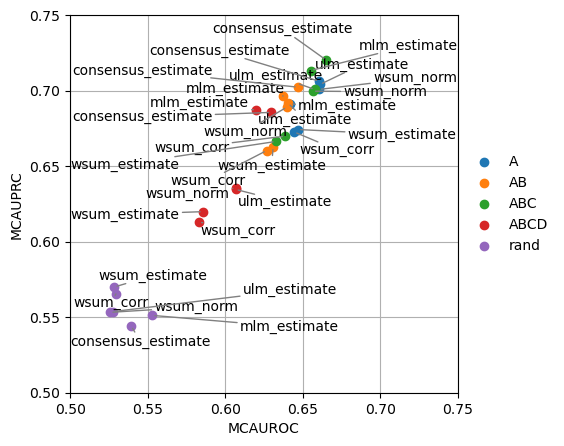

In [14]:
dc.plot_metrics_scatter(df, groupby='net', x='mcauroc', y='mcauprc')

Since this plot is too crowded, we can plot it again separating the methods by columns:

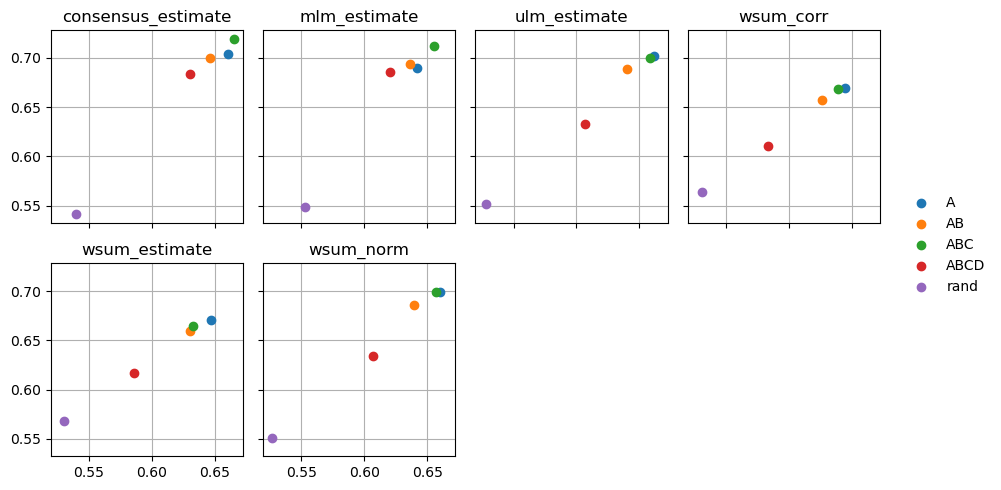

In [15]:
dc.plot_metrics_scatter_cols(df, col='method', figsize=(9, 5), groupby='net')

Or by selecting only one of the methods, in this case `consensus` since it is the most reliable method:

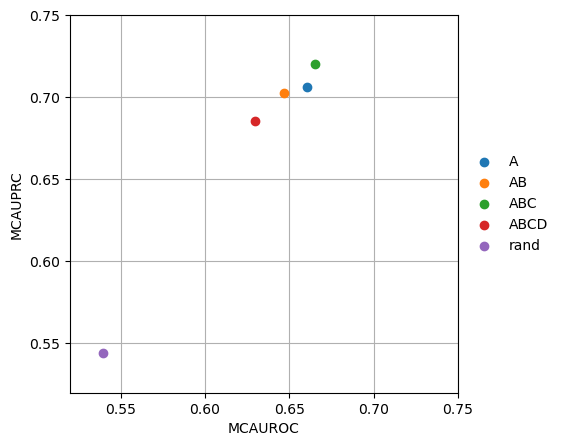

In [16]:
dc.plot_metrics_scatter(df[df['method'] == 'consensus_estimate'], groupby='net', x='mcauroc', y='mcauprc', show_text=False)

As expected, the random network has a performance close to 0.5 while the rest show higher predictive performance. The confidence levels ABC seem to give the best tradeoff between TF coverage and predictability.

If needed, we can also plot the distributions of the Monte-Carlo metrics, now grouped by network:

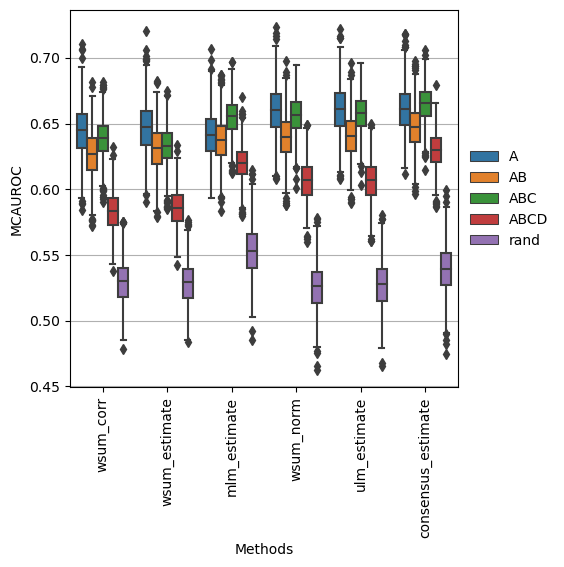

In [17]:
dc.plot_metrics_boxplot(df, metric='mcauroc', groupby='net')

### By source

The benchmark pipeline also allows to test the performance of individual regulators using the argument `by='source'`. For simplicity let us just use the best performing network:

In [18]:
# Example on how to set up decouple arguments
decouple_kws={
    'args' : {
        'wsum' : {'times': 100}
    }
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, doro_ABC, perturb='TF', sign=-1, by='source', verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
174 experiments without sources in net, they will be removed.
Running methods...
55 features of mat are empty, they will be removed.
Running mlm on mat with 214 samples and 21930 targets for 297 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


55 features of mat are empty, they will be removed.
Running ulm on mat with 214 samples and 21930 targets for 297 sources.
55 features of mat are empty, they will be removed.
Running wsum on mat with 214 samples and 21930 targets for 297 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


Calculating metrics...
Computing metrics...
Done.


We can plot the results with:

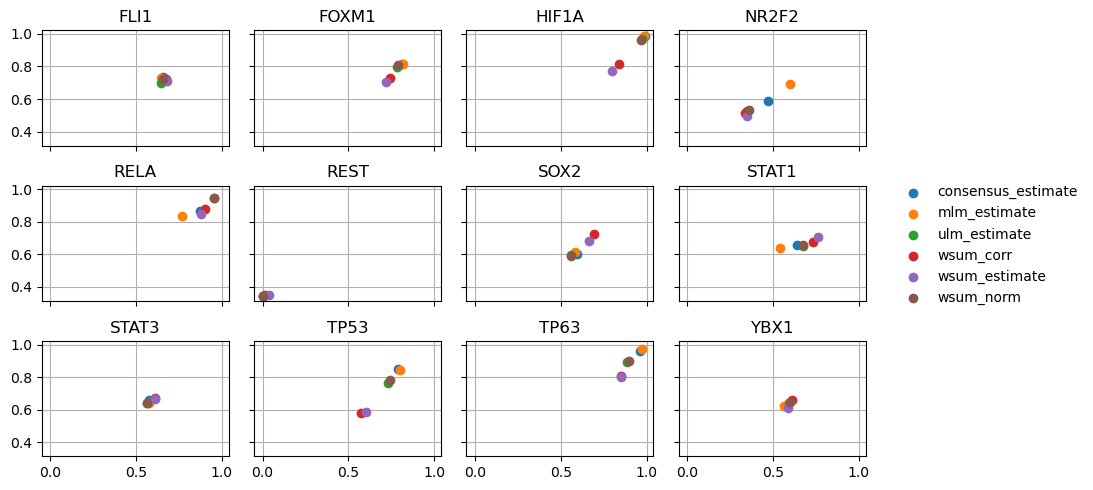

In [19]:
dc.plot_metrics_scatter_cols(df, col='source', figsize=(9, 5), groupby='method')

It looks like we get good predictions for FXM1, HIF1A and RELA among others. On the other side, we get bad predictions for YBX1, STAT3 and NR2F2 indicating that the topology of the network is not informative for these TFs. REST is an interesting case, we always missclassify it, meaning that the weights in the network for it should be reversed but the topology is good.

### By meta-data groups

The benchmarking pipeline can also be run by grouping the input experiments using the `groupby` argument. Multiple groups can be selected at the same time but for simplicity, we will just test which knockout method seems to perform the best inhibitions:

In [20]:
# Example on how to set up decouple arguments
decouple_kws={
    'args' : {
        'wsum' : {'times': 100}
    }
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, doro_ABC, perturb='TF', sign=-1, groupby='Knock.Method', verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
174 experiments without sources in net, they will be removed.
Running methods...
55 features of mat are empty, they will be removed.
Running mlm on mat with 214 samples and 21930 targets for 297 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


55 features of mat are empty, they will be removed.
Running ulm on mat with 214 samples and 21930 targets for 297 sources.
55 features of mat are empty, they will be removed.
Running wsum on mat with 214 samples and 21930 targets for 297 sources.
Infering activities on 1 batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.21s/it]


Calculating metrics...
Computing metrics for groupby Knock.Method...
Done.


Again, we can visualize the results in a collection of scatterplots:

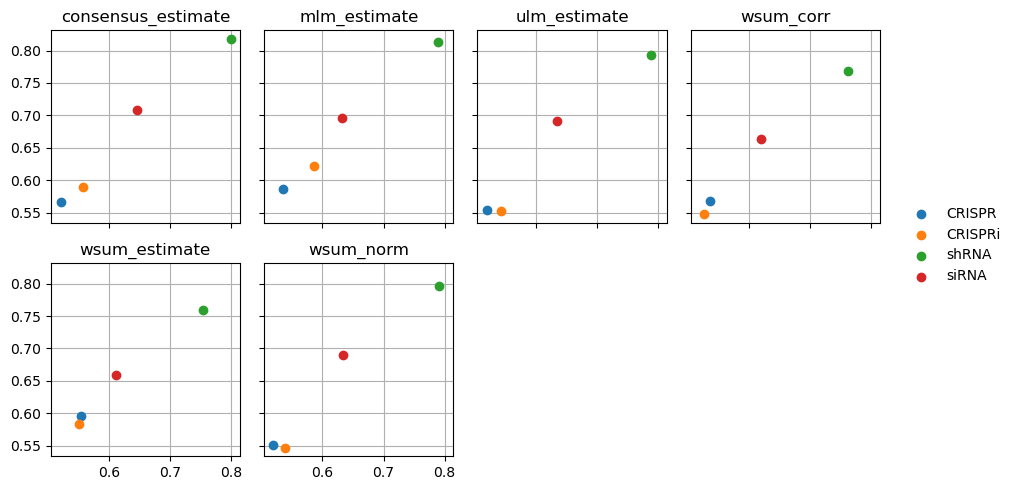

In [21]:
dc.plot_metrics_scatter_cols(df, col='method', figsize=(9, 5), groupby='group')

From our limited data-set, we can see that apparently shRNA works better than other knockout protocols.